## Project Overview

In this experiment, we investigate how randomly generated variables, when convolved with a moving‐average filter to introduce autocorrelation, can nonetheless be predicted remarkably well by a regression regressorwhen evaluated with a naive, random train/test split. However, by using a time‐aware split (e.g., `TimeSeriesSplit` expnading-window or sliding‐window) that respects the sequential nature of the data, we reveal that this performance is wholly driven by autocorrelation rather than genuine predictive signal.

The main objectives are:

1. **Generate six random signals** (x1–x5 as features and y as the target) of length 1000, each with a controllable level of autocorrelation.
2. **Train an XGBoost regressor** to predict y from x1–x5.
  - **Random 75/25 split**, which can mix past and future points and mask the lack of true signal.
  - **Time‐aware split** (e.g. `TimeSeriesSplit` expanding-window or sliding‐window), which respects temporal order and reveals that there is actually no real predictability.
3. **Observe how the strength of autocorrelation** (controlled by the “correlation window” in a moving average) affects regressor performance.
4. **Demonstrate the danger of spurious correlation**: even though all inputs are intrinsically random, the regressor’s predictive accuracy increases dramatically when autocorrelation is higher.
5. **Raise awareness** that hidden autocorrelation in real‐world features can lead to deceptively high performance.

---

## ACF and PACF

- **Autocorrelation Function (ACF):**  
  - Shows the correlation of the signal with its own past values at different lags.  
  - ACF at lag _k_ measures how well the series at time _t_ correlates with the series at time _t–k_.  

- **Partial Autocorrelation Function (PACF):**  
  - Shows the correlation between the signal and its lagged values **after removing** the effects of all shorter lags.  
  - PACF at lag _k_ measures the correlation between $x_t$ and $x_{t-k}$ after accounting for intermediate lags (1,…, _k–1_).  
  
- **Key Difference:**  
  - **ACF** includes both direct and indirect correlations (e.g., correlation at lag 3 might be driven by lag 1 and lag 2).  
  - **PACF** isolates only the direct correlation at each lag by removing indirect effects from intermediate lags.

---

## Methodology

1. **Signal Generation**  
   - For each signal, generate pure Gaussian noise:  
     ```python
     noise = np.random.normal(0, 1, length)
     ```  
   - Create a moving‐average window of size _w_:  
     ```python
     window = np.ones(w) / w
     ```  
   - Convolve the noise with this window (using `mode='same'`) to produce a signal with autocorrelation:  
     ```python
     signal = np.convolve(noise, window, mode='same')
     ```  
   - Repeat this process six times (five features and one target) for each choice of _w_.

2. **Varying Autocorrelation Strength**  
   - The parameter `correlation_window = w` determines how “smooth” (autocorrelated) each signal is.  
   - Lower _w_ (e.g., _w_ = 10) creates mild autocorrelation; higher _w_ (e.g., _w_ = 50) produces strong autocorrelation.

3. **Train/Test Split**  
   - Stack the six signals into a single DataFrame of shape (1,000 samples × 6 columns).  
   - Perform a random 75/25 train/test split.  
   - Features: columns `x1, x2, x3, x4, x5`  
   - Target: column `y`

4. **regressoring with XGBoost**  
   - Initialize an `XGBRegressor` with four hyperparameters.  
   - Fit on the training set.  
   - Predict on the test set and compute these metrics:  
     - **MSE** (Mean Squared Error)  
     - **RMSE** (Root Mean Squared Error)  
     - **MAE** (Mean Absolute Error)  
     - **$R^2$** (Coefficient of Determination)

5. **Comparison Across Windows**  
   - Repeat steps 1–4 for different window sizes (e.g., 1 and 50) to quantify how regressor performance changes as autocorrelation increases.

---

## Interpretation of Metrics

- **MSE (Mean Squared Error)**:  
  - Measures the average of the squared differences between predictions and true values. Lower is better; perfect regressor → 0.  
  - When autocorrelation is low (w = 1), MSE is relatively large (1.2761). When autocorrelation is high (w = 50), MSE is much smaller (0.0075).

- **RMSE (Root Mean Squared Error)**:  
  - Square root of MSE, expressed in the same units as y. Lower is better.  
  - w = 1 → 1.1296  
  - w = 50 → 0.0864

- **MAE (Mean Absolute Error)**:  
  - Average absolute deviation between predictions and true values. More robust to outliers. Lower is better.  
  - w = 1 → 0.8667  
  - w = 50 → 0.0629

- **$R^2$ (Coefficient of Determination)**:  
  - Fraction of variance in y explained by the regressor.  
  - w = 1 → -0.218 (regressor is worse than always predicting the mean)  
  - w = 50 → 0.6544 (regressor explains ~70% of variance)

---

## K-Fold Cross-Validation
  A resampling technique to estimate how well a model will generalize. It splits the data into **k** subsets (“folds”), train on **k−1** folds, validate on the remaining fold, and repeat so each fold serves once as the validation set. Averaging the scores gives a robust estimate of performance.

## Time-Series CV Variants

### 1. Forward-Chaining (Expanding Window)
- **Key point:** The training set **grows** each fold; it never uses “future” data to predict “past.”
- **When to use:** leveraging all historical data but still avoid look-ahead bias.

### 2. Sliding Window
- **Key point:** Both train and test windows remain the same length; it “forgets” the oldest data as it moves forward.  
- **When to use:** Ideal for non-stationary data or concept drift, since the model always trains on the most recent observations.




## [Sliding Window vs. Forward-Chaining (Expanding Window)](https://medium.com/@pradip.samuel/cross-validation-in-time-series-model-b07fbba65db7)

<div style="text-align: center;">
  <img src="pictures/1_eDhIeekv2HkUHTiWUZ_dcg.webp" alt="CV Schematic" width="400px"/>
</div>

<br>

<center>

| Strategy             | Train Size              | Test Size             | Movement                  |
|----------------------|-------------------------|-----------------------|---------------------------|
| **Sliding Window**   | Constant (user-defined) | Constant (user-defined) | Slide both forward       |
| **Forward-Chaining** | Expanding               | Constant (user-defined) | Expand train, slide test |

</center>

---

## Results

Below is a comparison of mean ($R^2$) across different correlation windows for three validation strategies:

- **Random 75/25 split**  
  A single train/test split where 75% of the data is used for training and 25% for testing (randomly shuffled).

- **Expanding-window Time-Series CV (5 folds)**  
  Each fold’s test set is 166 samples (≈16.6% of 1000), and the training set grows over time; we compute ($R^2$) on each test fold and then average the five scores.

- **Sliding-window Time-Series CV (5 folds)**  
  At each fold, the most recent 75% of the available data is used for training and the next 25% for testing; we compute ($R^2$) on each test fold and then average the five scores. 

<img src="pictures/R2_comparison.png"
     alt="R² Comparison"
     width="400px"
     style="float: left; margin: 0 20px 10px 0;" />


The bar chart shows that under a random holdout split, the regressor’s mean ($R^2$) appears to improve with increasing autocorrelation (larger moving‐average windows). In contrast, the sliding‐window cross‐validation yields near‐zero or negative mean ($R^2$) across all windows. Therefore, that the apparent predictive power under the random split is driven by spurious autocorrelation rather than any genuine signal.

<div style="clear: both;"></div>

---

## Key Takeaways

1. **Spurious Predictability**  
   - Even though all features and the target began as independent random noise, applying a moving average filter introduces hidden autocorrelation.  
   - XGBoost learns this autocorrelation structure, resulting in surprisingly high predictive accuracy when autocorrelation is strong.

2. **Real‑World Danger**  
   - In practice, features may have unintended autocorrelation (e.g., time‑series data with trend or seasonality).  
   - Training a regressor without checking for autocorrelation can produce deceptively good results that do not generalize.

3. **Recommendation**  
   - **Always check for autocorrelation** (and other hidden structures) in your features before regressor training.  
   - If features share autocorrelation with the target, remove or regressor that structure explicitly to avoid overoptimistic performance.

4. **Proper Validation Strategy**  
   - Use time-aware train/test splits (e.g. `TimeSeriesSplit` expanding-window or sliding-window) rather than random shuffles to respect temporal dependencies.  
   - Under a proper split, the apparent gains vanish—revealing that there is no genuine signal to learn.

---

## Conclusion

- We generated random signals and introduced autocorrelation using a moving average.  
- We observed that, as the correlation window increased, XGBoost performance improved dramatically, even though no true causal relationship existed.  
- This exercise highlights the importance of diagnosing autocorrelation (and other hidden dependencies) in real datasets to ensure regressors are genuinely learning meaningful patterns.  

<br><br>

In [3]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    cross_val_score,
    TimeSeriesSplit,
)
from matplotlib.patches import Patch
import plotly.graph_objects as go

# Data Creation

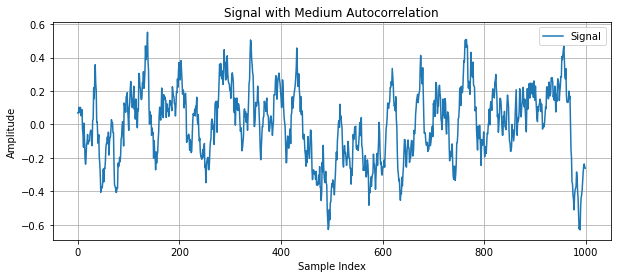

In [4]:
def generate_signal(length=1000, correlation_window=10):
    """
    Generates a signal with medium autocorrelation.

    Parameters:
        length (int): Length of the signal.
        correlation_window (int): Size of the window for the moving average to control correlation strength.

    Returns:
        np.ndarray: Signal with medium autocorrelation.
        
    *Note*: the "correlation_window" must be less than the "length"
    """
    # Generate random noise
    noise = np.random.normal(0, 1, length)
   
    # Create a moving average filter
    window = np.ones(correlation_window) / correlation_window
   
    # Apply the moving average filter to introduce correlation
    signal = np.convolve(noise, window, mode='same')
   
    return signal

# Generate the signal
signal = generate_signal(length=1000, correlation_window=20)
noise = np.random.normal(0, 1, 1000)

# Plot the signal
plt.figure(figsize=(10, 4))
# plt.plot(np.random.normal(0, 1, 1000))
plt.plot(signal, label="Signal")
plt.title("Signal with Medium Autocorrelation")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

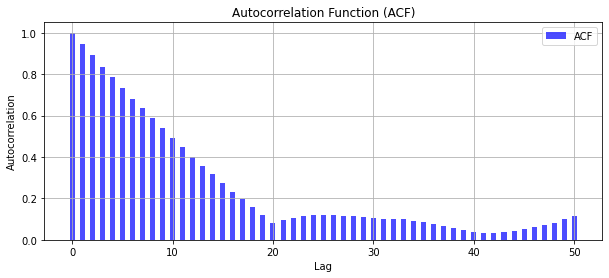

In [5]:
# Calculate the ACF of the signal
lags = 50  # Number of lags to compute
autocorr_values = acf(signal, nlags=lags, fft=True)

# Plot the ACF
plt.figure(figsize=(10, 4))
plt.bar(range(lags + 1), autocorr_values, width=0.5, color='blue', alpha=0.7, label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.legend()
plt.show()

# Display the ACF values for the first few lags
# autocorr_values[:10]  # Show ACF values for lags 0 through 9

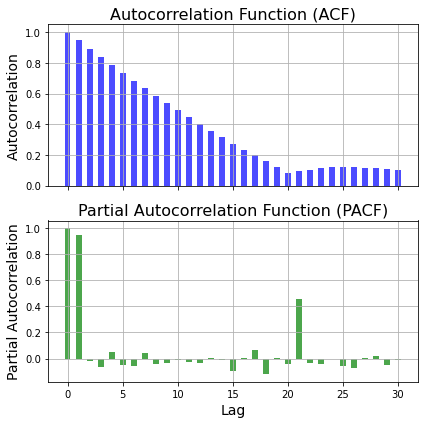

In [6]:
# Number of lags
lags = 30

# Compute ACF and PACF
acf_values = acf(signal, nlags=lags, fft=True)
pacf_values = pacf(signal, nlags=lags, method='ywm')

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# ACF plot
axes[0].bar(range(lags + 1), acf_values, width=.5, color='blue', alpha=0.7)
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=16)
axes[0].set_ylabel("Autocorrelation", fontsize=14)
axes[0].grid(True)

# PACF plot
axes[1].bar(range(lags + 1), pacf_values, width=0.5, color='green', alpha=0.7)
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=16)
axes[1].set_xlabel("Lag", fontsize=14)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Six Features and One Target

In [7]:
# Set a fixed seed for reproducibility
np.random.seed(42)

# Number of variables and samples
num_var = 6
num_samples = 1000
correlation_window = 10

# Generate 6 variables with the length of 1000 with medium autocorrelation
variables = [generate_signal(num_samples, correlation_window) for _ in range(num_var)]

# Create a dataframe where each variable is a column
df = pd.DataFrame(np.column_stack(variables), columns=[f'x{i}' for i in range(1,6)] + ['y'])

# Add an 'index' column at the front, where the values are the index of the data
df.insert(0, 'index', df.index)

df.head()

,index,x1,x2,x3,x4,x5,y
0,0,0.229501,0.243491,-0.381369,-0.073756,-0.177091,-0.227008
1,1,0.206088,0.282839,-0.360040,-0.207304,-0.117834,-0.354431
2,2,0.364009,0.372358,-0.359919,-0.158700,-0.388273,-0.249583
3,3,0.440753,0.435876,-0.441628,-0.313431,-0.451262,-0.200805
4,4,0.393805,0.540831,-0.375704,-0.205162,-0.500089,-0.274229


In [8]:
# help(xgb.XGBRegressor)

In [9]:
np.random.seed(42)
# Data and Target
data = df.drop(['y'], axis=1) # x1,...,x5
target = df['y']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.25)


# regressor Training

In [10]:
regressor = xgb.XGBRegressor(eval_metric='rmsle')

# Search for the optimal hyperparamers
param_grid = {'max_depth': [4,5,6,7],
              'n_estimators': [100,500,600,700],
              'learning_rate': [0.01,0.015,0.3]}

# Try every combination o fthe above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print('The best hyperparameters are ', search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}


In [11]:
# Create regressor instance
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

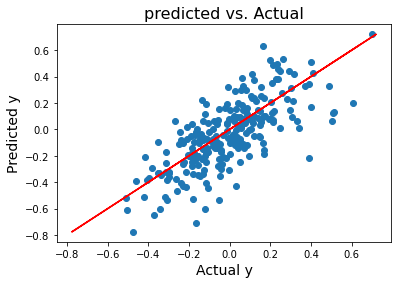

In [12]:
# Use the regressor to predict
predict = regressor.predict(X_test)

# Scatter plot of actual vs. predicted
plt.plot(y_test, y_test, color='red')
plt.scatter(predict, y_test)
plt.xlabel('Actual y', fontsize=14)
plt.ylabel('Predicted y', fontsize=14)
plt.title('predicted vs. Actual', fontsize=16)
plt.show()

In [13]:
# Mean Squared Error
mse = mean_squared_error(y_test, predict)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(y_test, predict)

# R-squared
r2 = r2_score(y_test, predict)

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R\u00B2  : {r2:.4f}")

Test MSE : 0.0316
Test RMSE: 0.1777
Test MAE : 0.1366
Test R²  : 0.5222


# Different Windows

In [14]:
def evaluate_for_windows(windows, num_samples=1000, test_size=.25):
    """
    Fro each correlation window in 'windows', generate data, train an XGBRegressor,
    and compute regression metrics.
    
    Parameters:
        windows (list of int): List of correlation window sizes to evaluate.
        num_samples (int): Number of samples per variable (default: 1000).
        test_size (float): Proportion of data to reserve for testing (default: 0.25).
    
    Returns:
        pd.DataFrame: A DataFrame summarizing MSE, RMSE, MAE, and R2 for each window.
    """
    result = []
    
    for window in windows:
        # Generate six signals (x1-x5 as features, y as target)
        signals = [generate_signal(length=num_samples, correlation_window=window) for _ in range(6)]
        df = pd.DataFrame(
            np.column_stack(signals),
            columns=[f'x{i}' for i in range(1,6)] + ['y']
        )
        
        # Split into train and test
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
        X_train, y_train = train_df[['x1', 'x2', 'x3', 'x4', 'x5']], train_df['y']
        X_test, y_test = test_df[['x1', 'x2', 'x3', 'x4', 'x5']], test_df['y']
        
        # train XGBRegressor
        regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

        regressor.fit(X_train, y_train)
        
        # Predict and compute metrics
        y_pred = regressor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        result.append({
            'correlation_window': window,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R\u00B2': r2
        })
        
    return pd.DataFrame(result)

In [15]:
windows_to_test = [1,5,10,50,100]
metrics_df = evaluate_for_windows(windows_to_test)

metrics_df

,correlation_window,MSE,RMSE,MAE,R²
0,1,1.399251,1.182899,0.926300,-0.180573
1,5,0.218433,0.467368,0.369630,-0.041366
2,10,0.064759,0.254478,0.202397,0.099760
3,50,0.005140,0.071692,0.053634,0.715451
4,100,0.001302,0.036086,0.024375,0.803508


# Cross Validation

## Time Series

In [21]:
def plot_cross_val(splitter_func,
                   df: pd.DataFrame,
                   title_text: str) -> None:
  
    """Function to plot the cross validation of various
    sklearn splitter objects."""

    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func.split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
    # for train_index, valid_index in splitter_func.split(df):
    #     plot_data.append([train_index, 'Train', split])
    #     plot_data.append([valid_index, 'Test',  split])
        split += 1

    plot_df = pd.DataFrame(plot_data,
                           columns=['Index', 'Dataset', 'Split'])\
                           .explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=14),
                       title=dict(text=title_text, y=0.95), title_x=0.5, width=550,
                      margin=dict(t=60, b=10, l=20, r=20),
                      height=300, xaxis_title='Index', yaxis_title='Fold')
    
    fig.update_yaxes(categoryorder='array',
                    categoryarray=[str(i) for i in range(1, split+1)])


    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    fig.show()
    return fig


# Times Series Cross-Validation (Expanding Window)
ts_expandWindow = TimeSeriesSplit(
    n_splits=5
)
fig_ts_expandWindow = plot_cross_val(splitter_func=ts_expandWindow,
                                     df=data,
                                     title_text='Time Series Cross-Validation (Expanding Window)')

# Times Series Cross-Validation (Sliding Window)
ts_slideWindow = TimeSeriesSplit(
    n_splits=5,
    max_train_size=375,
    test_size=125,
    gap=0
)
fig_ts_slideWindow = plot_cross_val(splitter_func=ts_slideWindow,
                                    df=data,
                                    title_text='Time Series Cross-Validation (Sliding Window)')

In [23]:
fig_ts_expandWindow.write_image("expand_cv.png")
fig_ts_slideWindow.write_image("slide_cv.png")

![Expanding Window](expand_cv.png)
![Expanding Window](slide_cv.png)

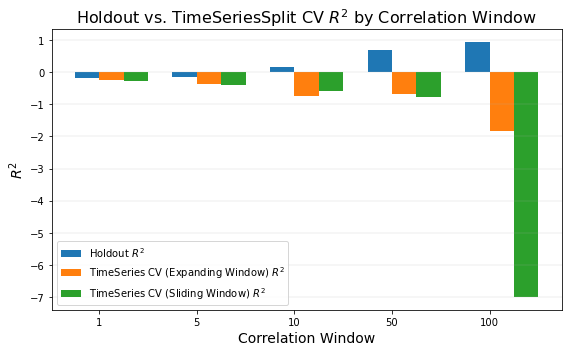

In [ ]:
windows = [1, 5, 10, 50, 100]
num_samples = 1000
num_var = 6

results = []

for w in windows:
    variables = [generate_signal(num_samples, w) for _ in range(num_var)]
    df = pd.DataFrame(
        np.column_stack(variables),
        columns=[f'x{i}' for i in range(1,6)] + ['y']
    )

    data = df.drop(['y'], axis=1)
    target = df['y']

    # 1) Holdout split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42, shuffle=True)
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    holdout_r2 = r2_score(y_test, y_pred)
    
    # 2) TimeSeriesSplit CV (Expanding Window)
    ts_expandWindow = TimeSeriesSplit(n_splits=5)
    ts_expandWindow_r2_scores = []
    for train_idx, test_idx in ts_expandWindow.split(data):
        regressor.fit(data.iloc[train_idx], target.iloc[train_idx])
        y_ts_pred = regressor.predict(data.iloc[test_idx])
        ts_expandWindow_r2_scores.append(r2_score(target.iloc[test_idx], y_ts_pred))
    ts_expandWindow_r2 = np.mean(ts_expandWindow_r2_scores)
    
    # 3) TimeSeriesSplit CV (Sliding Window)
    ts_slideWindow= TimeSeriesSplit(n_splits=5, max_train_size=375, test_size=125, gap=0)
    ts_slideWindow_r2_scores = []
    for train_idx, test_idx in ts_slideWindow.split(data):
        regressor.fit(data.iloc[train_idx], target.iloc[train_idx])
        y_ts_pred = regressor.predict(data.iloc[test_idx])
        ts_slideWindow_r2_scores.append(r2_score(target.iloc[test_idx], y_ts_pred))
    ts_slideWindow_r2 = np.mean(ts_slideWindow_r2_scores)

    results.append({
        'window': w,
        'holdout_r2': holdout_r2,
        'ts_expandWindow_r2': ts_expandWindow_r2,
        'ts_slideWindow_r2': ts_slideWindow_r2
    })

metrics_df = pd.DataFrame(results)


ind = np.arange(len(windows))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(ind, metrics_df['holdout_r2'], width, label=r'Holdout $R^2$')
plt.bar(ind + width, metrics_df['ts_expandWindow_r2'], width, label=r'TimeSeries CV (Expanding Window) $R^2$')
plt.bar(ind + width*2, metrics_df['ts_slideWindow_r2'], width, label=r'TimeSeries CV (Sliding Window) $R^2$')
plt.xlabel('Correlation Window', fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)
plt.title(r'Holdout vs. TimeSeriesSplit CV $R^2$ by Correlation Window', fontsize=16)
plt.xticks(ind + width/2, windows)
plt.legend()
plt.grid(axis='y', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig("R2_comparison.png", bbox_inches="tight", facecolor="white", transparent=False)
plt.show()

## K-Fold

In [ ]:
windows = [1, 5, 10, 50, 100]
num_samples = 1000
num_var = 6

kf = KFold(n_splits=5)

kf_results = []
for w in windows:
    variables = [generate_signal(num_samples, w) for _ in range(num_var)]
    df = pd.DataFrame(
        np.column_stack(variables),
        columns=[f'x{i}' for i in range(1,6)] + ['y']
    )
    
    data = df.drop(['y'], axis=1) # x1,...,x5
    target = df['y']
    
    
    scores = cross_val_score(regressor, data, target, cv=kf, scoring='r2')
    for fold, score in enumerate(scores, start=1):
        kf_results.append({'window': w, 'fold': fold, 'r2': score})

scores_df = pd.DataFrame(kf_results)

mean_r2_df = (
    scores_df
    .groupby('window', as_index=False)
    .agg(mean_r2=('r2', 'mean'))
)

mean_r2_df

,window,mean_r2
0,1,-0.191957
1,5,-0.254546
2,10,-0.445893
3,50,-0.612953
4,100,-5.620375
